# Analyses of the Functional Connectivity and correlation between FC and SC features from the TVB-AdEx parameter sweep

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os

from JUSUFlike.Project.Codes.processing_results import *
from IPython.display import Image
import tvb_model_reference.src.nuu_tools_simulation_human as tools
from sklearn.cluster import KMeans

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})

fig_labels = ['$S$', '$b_e$ (pA)', '$E_{L,i}$ (mV)', '$E_{L,e}$ (mV)', '$T$ (ms)']

c:\users\david\appdata\local\programs\python\python38\lib\site-packages\tvb\datatypes\surfaces.py:64: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
from matplotlib.collections import LineCollection

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings
    Author: ahwillia from StackOverflow.
    Obtained from:
    https://stackoverflow.com/questions/38208700/matplotlib-plot-lines-with-colors-through-colormap
    
    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

In [3]:
data_FC = np.load('./data/FCprocessed.npy')
data_FCSC = np.load('./data/corrFCSCprocessed.npy')
# Each data contains 25980 parameter combinations of a, ELI, ELE and T.
# The first 16 columns contain the feature value (mean FC or corrFCSC) for 16 values
# of b linspaced from 0 to 120. The last 4 columns contain, in this order, the values of the
# long-range coupling strength (S), inhibitory leak voltage potential (ELI),
# excitatory leak voltage potential (ELE) and time-scale of the mean field model (T).

In [4]:
print(data_FC.shape)
print(data_FC[0])

(25890, 20)
[ 2.21309369e-03  2.27501210e-03  2.45345381e-03  2.54308044e-03
  2.44821817e-03  2.50659582e-03  2.56881965e-03  2.63031757e-03
  2.73325922e-03  2.80752725e-03  2.84274824e-03  2.84199465e-03
  2.82092117e-03  2.78713674e-03  2.74530219e-03  2.69853402e-03
  3.30000000e-02 -8.00000000e+01 -8.00000000e+01  5.00000000e+00]


What I have in mind is plotting the traces, for one parameter combination and changing one parameter with a color code (I think that S might be an interesting value).

In [17]:
def feat_ev_with_b(fixed_pars, free_par, data, steps=16):
    '''Function that plots the evolution of a feature (either mean FC or corrFCSC) when changing
    the value of spike-frequency adaptation (b_e parameter). Three parameters are fixed and one is
    left free to change, color coding will encode the value of the free parameter.
    
    Parameters
    ----------
    fixed_pars: dict
        Contains the name of the parameter as key and the parameter value as value of key.
        
    free_par: str
        Key of the parameter that is left to change free and that will be color coded.
    
    data: ndarray (N, 20)
        Numpy array where each row contains the information of a parameter combination. In each row,
        the first 16 values are the feature value for each b_e value from 0 to 120 (linspaced with 16
        elements). The remaining 4 values are, in order, the values of the
        long-range coupling strength (S), inhibitory leak voltage potential (ELI),
        excitatory leak voltage potential (ELE) and time-scale of the mean field model (T)
    
    steps: int
        Number of values per parameter used for the parameter sweep.
    
    Returns
    ----------
    fig: matplotlib figure
        Figure containing the curves of the feature evolution.
    '''
    idxes_pars = {'a': 16, 'E_L_i': 17, 'E_L_e': 18, 'T': 19}
    for param in fixed_pars:
        fixed_pars[param] = find_closest_val(param, fixed_pars[param], steps)
    
    for i, fixed_param in enumerate(fixed_pars):
        fix_par_idx_in_arr = idxes_pars[fixed_param]
        if i == 0:
            bool_idxs = data[:, fix_par_idx_in_arr] == fixed_pars[fixed_param]
        else:
            bool_idxs = (data[:, fix_par_idx_in_arr] == fixed_pars[fixed_param]) & bool_idxs
    

    data_plot = np.concatenate((data[bool_idxs, :16], 
                                data[bool_idxs, idxes_pars[free_par]][:, np.newaxis]), 
                               axis=1)

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    bs = np.linspace(0, 120, steps)

    lc = multiline(xs=np.tile(bs, (data_plot.shape[0], 1)), 
                   ys=data_plot[:,:-1], c=data_plot[:,-1], ax=ax)

    axcb = fig.colorbar(lc)

    ax.set(ylabel='corrFCSC',  xlabel=fig_labels[1])
    
    pars_title = {'a': '$S$', 'E_L_i': '$E_{L,i}$', 'E_L_e': '$E_{L,e}$', 'T': '$T$'}
    pars_title_units = {'a': '', 'E_L_i': 'mV', 'E_L_e': 'mV', 'T': 'ms'}
    title_str = 'Evolution of corrFCSC with $b_e$ for:\n'
    for fixed_param in fixed_pars:
        title_str += pars_title[fixed_param] + \
        ' = ' + str(fixed_pars[fixed_param]) + ' ' + pars_title_units[fixed_param] + ', '
    
    ax.set_title(title_str[:-2])
    if free_par != 'a':
        axcb.set_label(pars_title[free_par] + ' [' + pars_title_units[free_par] + ']')
    else:
        axcb.set_label(pars_title[free_par])
    return fig

## Effect of S in the evolution of corrFCSC

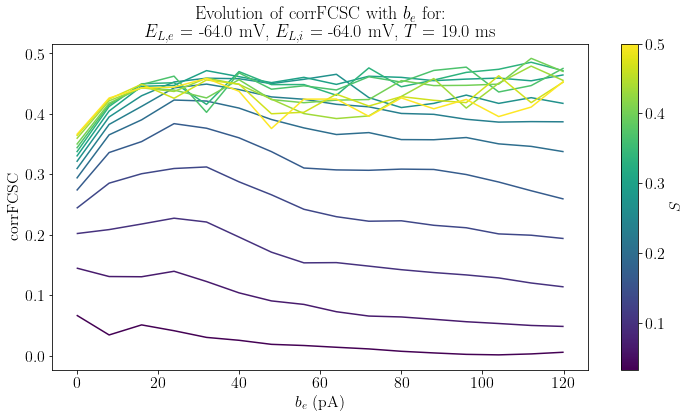

In [18]:
# Select a parameter combination for obtaining the plot (select values in the range)
# This can be later modified by the function I wrote (get_closest_to_val) or something like that
fixed_pars = {'E_L_e': -64.0, 'E_L_i': -64.0, 'T': 19.0}
free_par = 'a'
fig = feat_ev_with_b(fixed_pars, free_par, data_FCSC, steps=16)
fig.savefig('./figures/article_figures/Fig5Supp1.pdf')
plt.show()

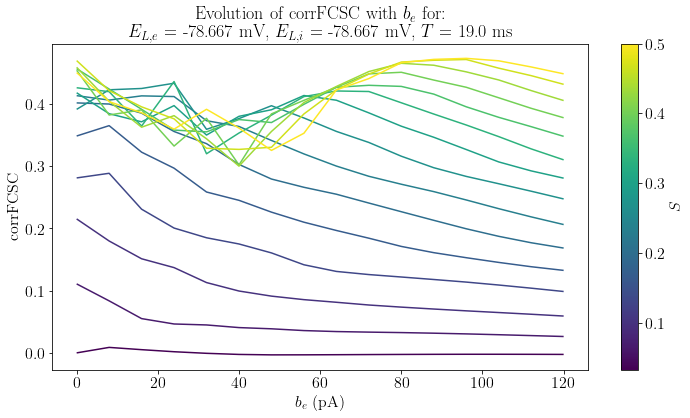

In [19]:
fixed_pars = {'E_L_e': -78.0, 'E_L_i': -78.0, 'T': 19.0}
free_par = 'a'
fig = feat_ev_with_b(fixed_pars, free_par, data_FCSC, steps=16)

plt.show()

## Effect of T in evolution of corrFCSC

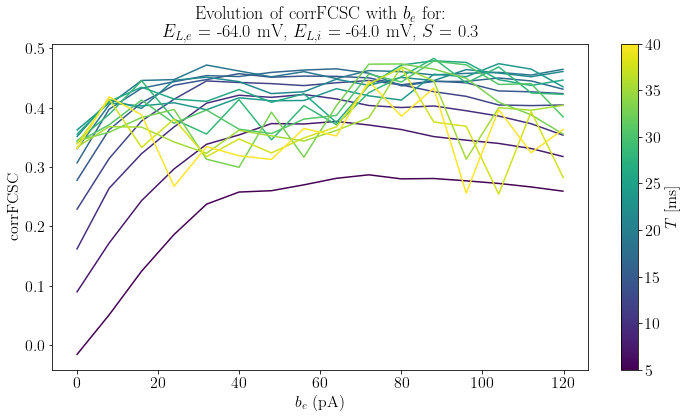

In [20]:
fixed_pars = {'E_L_e': -64.0, 'E_L_i': -64.0, 'a': 0.3}
free_par = 'T'
fig = feat_ev_with_b(fixed_pars, free_par, data_FCSC, steps=16)
fig.savefig('./figures/article_figures/Fig5Supp2.pdf')
plt.show()

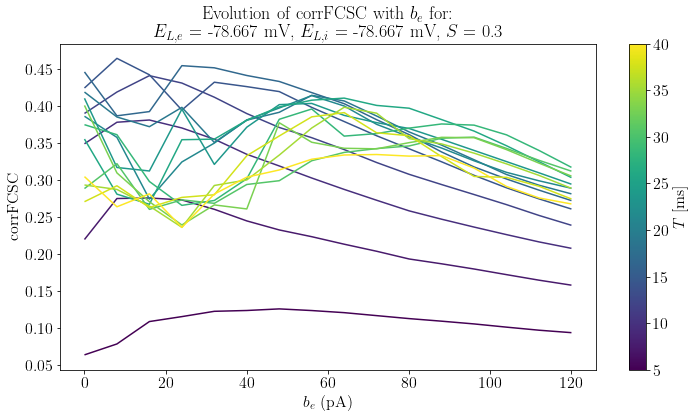

In [21]:
fixed_pars = {'E_L_e': -78.0, 'E_L_i': -78.0, 'a': 0.3}
free_par = 'T'
fig = feat_ev_with_b(fixed_pars, free_par, data_FCSC, steps=16)

plt.show()